In [79]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mutual_info_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

%matplotlib inline

In [20]:
df = pd.read_csv('course_lead_scoring.csv')

In [21]:
categorical = ['lead_source', 'industry', 'employment_status', 'location']

In [22]:
numerical = ['number_of_courses_viewed', 'annual_income', 'interaction_count', 'lead_score']

In [23]:
df[categorical] = df[categorical].fillna('NA')
df[numerical] = df[numerical].fillna(0.0)

In [24]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)

In [25]:
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

In [26]:
len(df_train), len(df_val), len(df_test)

(876, 293, 293)

In [27]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [28]:
y_train = df_train.converted.values
y_val = df_val.converted.values
y_test = df_test.converted.values

In [29]:
del df_train['converted']
del df_val['converted']
del df_test['converted']

In [30]:
df_full_train = df_full_train.reset_index(drop=True)

In [69]:
X = df[numerical]

feature_auc = {}

for col in X.columns:
    model = LogisticRegression(max_iter=1000)
    model.fit(df_train[[col]], y_train)
    y_pred = model.predict_proba(df_val[[col]])[:, 1]
    auc = roc_auc_score(y_val, y_pred)
    feature_auc[col] = auc

feature_importance = pd.Series(feature_auc).sort_values(ascending=False)
print(feature_importance)

number_of_courses_viewed    0.742211
interaction_count           0.697201
lead_score                  0.623190
annual_income               0.554357
dtype: float64


In [37]:
train_dicts = df_train[categorical + numerical].to_dict(orient='records')

In [42]:
dv = DictVectorizer(sparse=False)
dv.fit(train_dicts)
X_train = dv.transform(train_dicts)

In [43]:
val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [44]:
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'liblinear'
,max_iter,1000
,multi_class,'deprecated'


In [45]:
y_pred = model.predict_proba(X_val)[:, 1]

In [47]:
roc_auc_score(y_val, y_pred)

0.8171316268814112

In [71]:
def tpr_fpr_dataframe(y_val, y_pred):
    thresold = np.linspace(0.0, 1.0, 101)

    scoress = []
    
    for t in thresold:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)
    
        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)
    
        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()
    
        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()
    
        scoress.append((t, tp, tn, fp, fn))

    columns = ['thresold', 'tp', 'tn', 'fp', 'fn']
    df_score = pd.DataFrame(scoress, columns=columns)
        
    df_score['recall'] = df_score.tp / (df_score.fn + df_score.tp)
    df_score['precision'] = df_score.tp / (df_score.fp + df_score.tp)
    df_score['fpr'] = df_score.fp / (df_score.fp + df_score.tn)

    df_score['f1'] = 2 * ((df_score['precision'] * df_score['recall']) / (df_score['precision'] + df_score['recall']))

    return df_score

In [72]:
df_score = tpr_fpr_dataframe(y_val, y_pred)

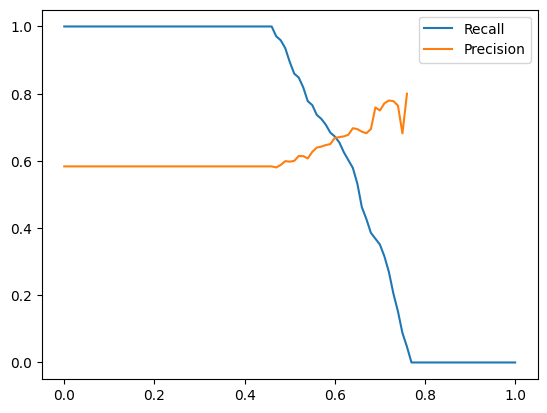

In [75]:
plt.plot(df_score['thresold'], df_score['recall'], label='Recall')
plt.plot(df_score['thresold'], df_score['precision'], label='Precision')
plt.legend()

In [73]:
df_score[::10]

,thresold,tp,tn,fp,fn,recall,precision,fpr,f1
0,0.0,171,0,122,0,1.000000,0.583618,1.000000,0.737069
10,0.1,171,0,122,0,1.000000,0.583618,1.000000,0.737069
20,0.2,171,0,122,0,1.000000,0.583618,1.000000,0.737069
30,0.3,171,0,122,0,1.000000,0.583618,1.000000,0.737069
40,0.4,171,0,122,0,1.000000,0.583618,1.000000,0.737069
50,0.5,153,19,103,18,0.894737,0.597656,0.844262,0.716628
60,0.6,115,65,57,56,0.672515,0.668605,0.467213,0.670554
70,0.7,60,102,20,111,0.350877,0.750000,0.163934,0.478088
80,0.8,0,122,0,171,0.000000,NaN,0.000000,NaN
90,0.9,0,122,0,171,0.000000,NaN,0.000000,NaN


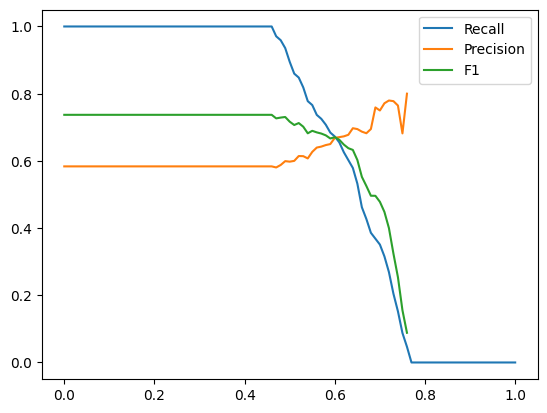

In [78]:
plt.plot(df_score['thresold'], df_score['recall'], label='Recall')
plt.plot(df_score['thresold'], df_score['precision'], label='Precision')
plt.plot(df_score['thresold'], df_score['f1'], label='F1')
plt.legend()

In [80]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

In [81]:
X = df_full_train[categorical + numerical]
y = df_full_train.converted.values

In [82]:
train_dicts = df_full_train[categorical + numerical].to_dict(orient='records')
X = dv.fit_transform(train_dicts)
y = df_full_train.converted.values

In [83]:
scores = []

for train_idx, val_idx in kfold.split(X):
    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model.fit(X_train, y_train)

    y_pred = model.predict_proba(X_val)[:, 1]  # get probability for positive class
    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

print('AUC scores per fold:', scores)
print('Mean AUC:', np.mean(scores))
print('Std AUC:', np.std(scores))


AUC scores per fold: [0.8060745924216483, 0.8713738368910783, 0.7754320118852139, 0.8018368617683685, 0.8558272713202291]
Mean AUC: 0.8221089148573075
Std AUC: 0.03580711942905165


In [84]:
C_values = [0.000001, 0.001, 1]

results = []

for C in C_values:
    scores = []
    
    for train_idx, val_idx in kfold.split(X):
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]
        
        model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
        model.fit(X_train, y_train)
        
        y_pred = model.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)
    
    mean_score = np.mean(scores).round(3)
    std_score = np.std(scores).round(3)
    results.append((C, mean_score, std_score))

# Display results
for C, mean_score, std_score in results:
    print(f"C={C}: mean AUC={mean_score}, std={std_score}")

# Find the best C
best = max(results, key=lambda x: x[1])
print(f"\nBest C is {best[0]} with mean AUC={best[1]} and std={best[2]}")


C=1e-06: mean AUC=0.56, std=0.024
C=0.001: mean AUC=0.867, std=0.029
C=1: mean AUC=0.822, std=0.036

Best C is 0.001 with mean AUC=0.867 and std=0.029
